# Appendix B:  Prophet Comparison Model
We used the Prophet modeling package from Facebook to build Arima models using our data. We computed RMSE for comparison with the Long-Short Term Memory neural networks. Results are comparable, suggesting that LSTM has utility as a modeling approach for cryptocurrency price prediction.

In [1]:
from fbprophet import Prophet
import pandas as pd
import numpy as np
import math
import matplotlib as plt
from matplotlib import pyplot as plt

# Disable logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

## Part 1: Data preparation
As described in Appendix A, we're importing a dataset of Bitcoin prices, market data, semantic scores and the  economic uncertainty index. The next few steps prepare the data for use with Prophet.

In [3]:
datafile = r'btc_new_3_24.csv'
data = pd.read_csv(datafile)
df=data

In [4]:
data.head()

,day,epu_idx,price,volume,bidask,tpm,trans,exp_sem
0,3/24/13,126.08,68.287939,3.361108e+06,0.761886,2.203646,51335,0.24065
1,3/25/13,178.57,73.648607,6.917269e+06,0.978241,2.824132,48993,0.20230
2,3/26/13,163.29,77.090928,5.322638e+06,0.931310,2.560417,49061,0.00000
3,3/27/13,177.06,85.256510,7.356470e+06,1.033937,3.198785,53207,0.21230
4,3/28/13,72.92,90.658741,1.477020e+07,1.555560,5.049826,60989,0.20240


In [5]:
data = data.reset_index(drop=True)

In [ ]:
# data['lagged'] = data.price.shift(-1)

In [6]:
# Preparing data for prophet
data.rename(columns={'day': 'ds'}, inplace=True)
data.rename(columns={'price': 'y'}, inplace=True)

In [7]:
# view data
data.tail()

,ds,epu_idx,y,volume,bidask,tpm,trans,exp_sem
1821,3/19/18,76.32,8390.472654,1.331577e+09,1.237513,44.369544,191528,0.095283
1822,3/20/18,79.32,8665.276738,9.671192e+08,0.931973,33.673810,195168,0.109729
1823,3/21/18,58.73,9038.338133,9.017038e+08,0.481224,30.921032,194846,0.159660
1824,3/22/18,54.22,8828.079342,9.567951e+08,0.339547,29.067163,185187,0.092254
1825,3/23/18,72.98,8574.364330,8.645390e+08,0.347265,30.230258,179818,0.113480


In [8]:
# Setting ds column to Datetimeindex
# data['ds'] = pd.DatetimeIndex(data['ds'])
data['ds'] = pd.to_datetime(data['ds'])

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 8 columns):
ds         1826 non-null datetime64[ns]
epu_idx    1826 non-null float64
y          1826 non-null float64
volume     1826 non-null float64
bidask     1826 non-null float64
tpm        1826 non-null float64
trans      1826 non-null int64
exp_sem    1826 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 114.2 KB


## 2. Predicting based on raw data
Prediction quality: 1012.71 RMSE

In [11]:
#Initialize model and fit it
m4 = Prophet()
m4.fit(data)

In [12]:
#build prediction ds
future_data = m4.make_future_dataframe(periods=1, freq = 'd')

In [13]:
#predict
f = m4.predict(future_data)

In [14]:
f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1822,2018-03-20,11522.381254,10223.043170,12847.623917
1823,2018-03-21,11561.475548,10253.061927,12808.412558
1824,2018-03-22,11608.775504,10381.008110,12929.189205
1825,2018-03-23,11657.170021,10428.119677,12914.226234
1826,2018-03-24,11741.378708,10471.236299,12918.508458


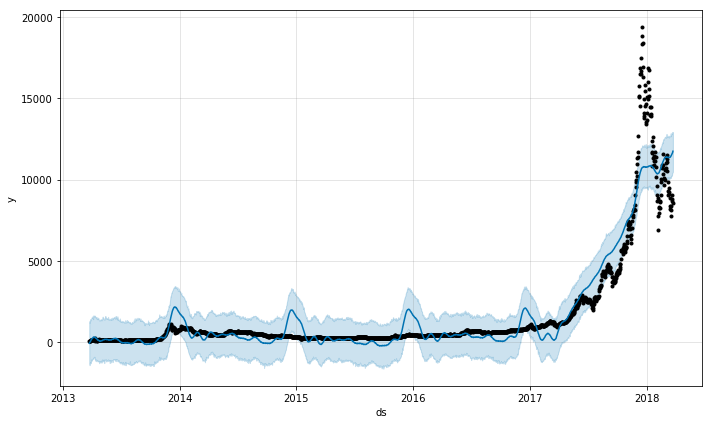

In [15]:
m4.plot(f)

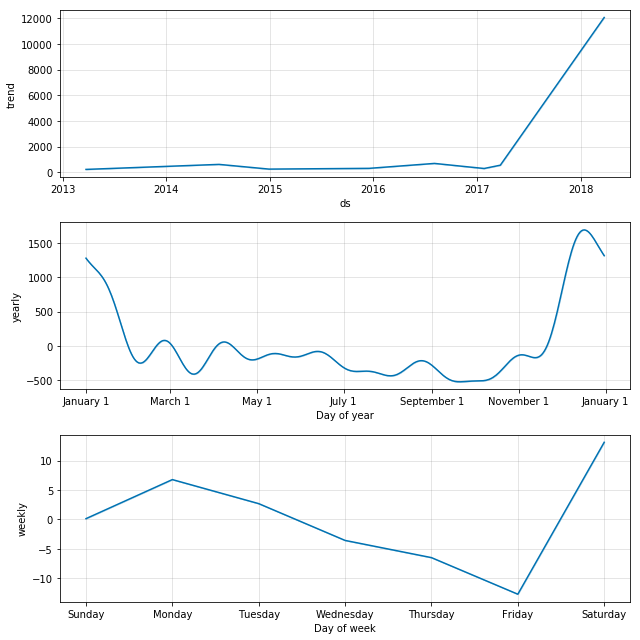

In [16]:
m4.plot_components(f)

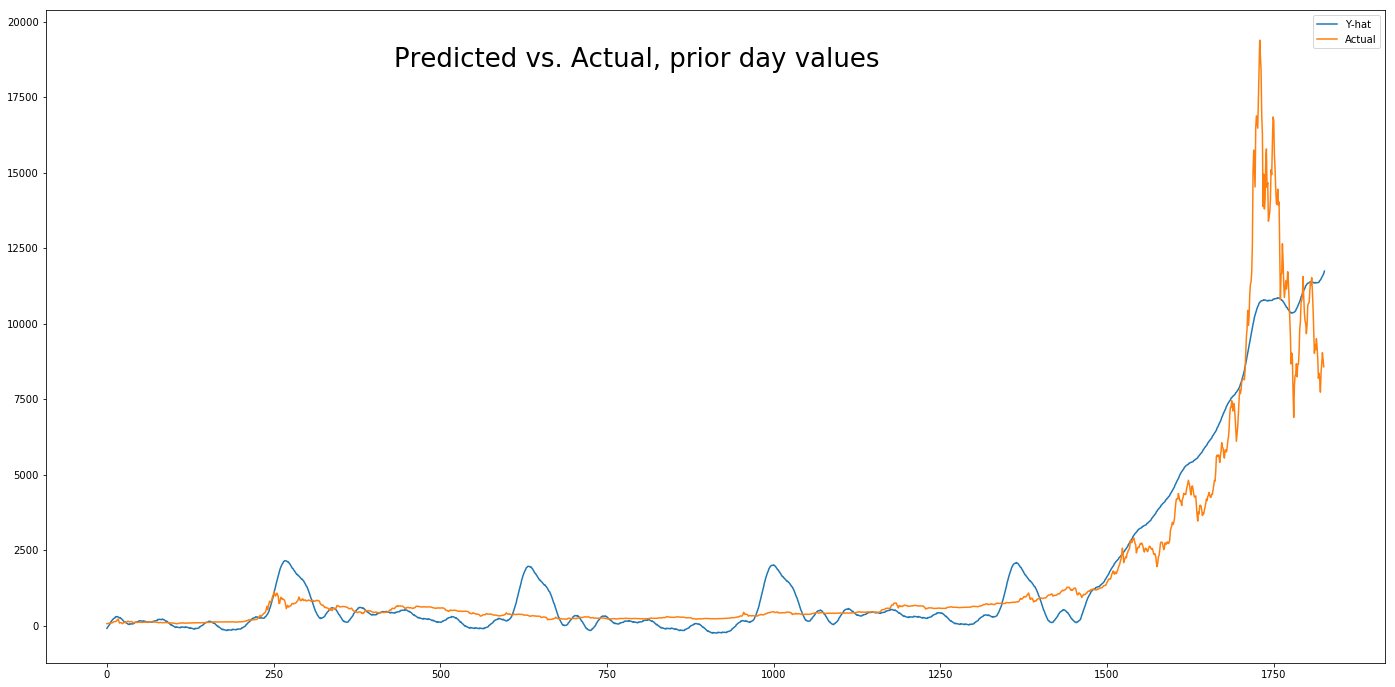

In [34]:

plt.figure(figsize=(24,12))
plt.plot(f['yhat'], label='Y-hat')
plt.plot(data['y'], label='Actual')
plt.legend(loc='best')
plt.text(430, 18500, 'Predicted vs. Actual, prior day values', fontsize=26)
plt.show()

In [18]:
#Calculate accuracy
y_hat = f['yhat']
y_true = data['y']

mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))


Prediction quality: 1025575.03 MSE (1012.71 RMSE)


## 3. Predicting based on Rolling window of 10 
This approach predicts next-day price based on a rolling window of data from the 10 prior days.  
  
Prediction quality: 296.56 RMSE

In [19]:
# Function to be called from the loop
def runmodel(df):
    m = Prophet()
    m.fit(df)
    future_data = m.make_future_dataframe(periods=1, freq = 'd')
    f = m.predict(future_data)
    return (f['yhat'][10])

In [20]:
# This will take some time to run.
# Looping through data and predicting based on 10 datapoint intervals.
y = []
p = []
for i in range(0,len(data)):
    if (i+11)>len(data):
        print ('Completed')
        break
        
    df_temp = data[i:i+10]
    y.append(runmodel(df_temp))
    p.append(data['y'][i+10])
    # print('Processed', i)
   

Completed


In [21]:
dfnew=pd.DataFrame({'y':y, 'price':p})

In [22]:
len(dfnew)

1816

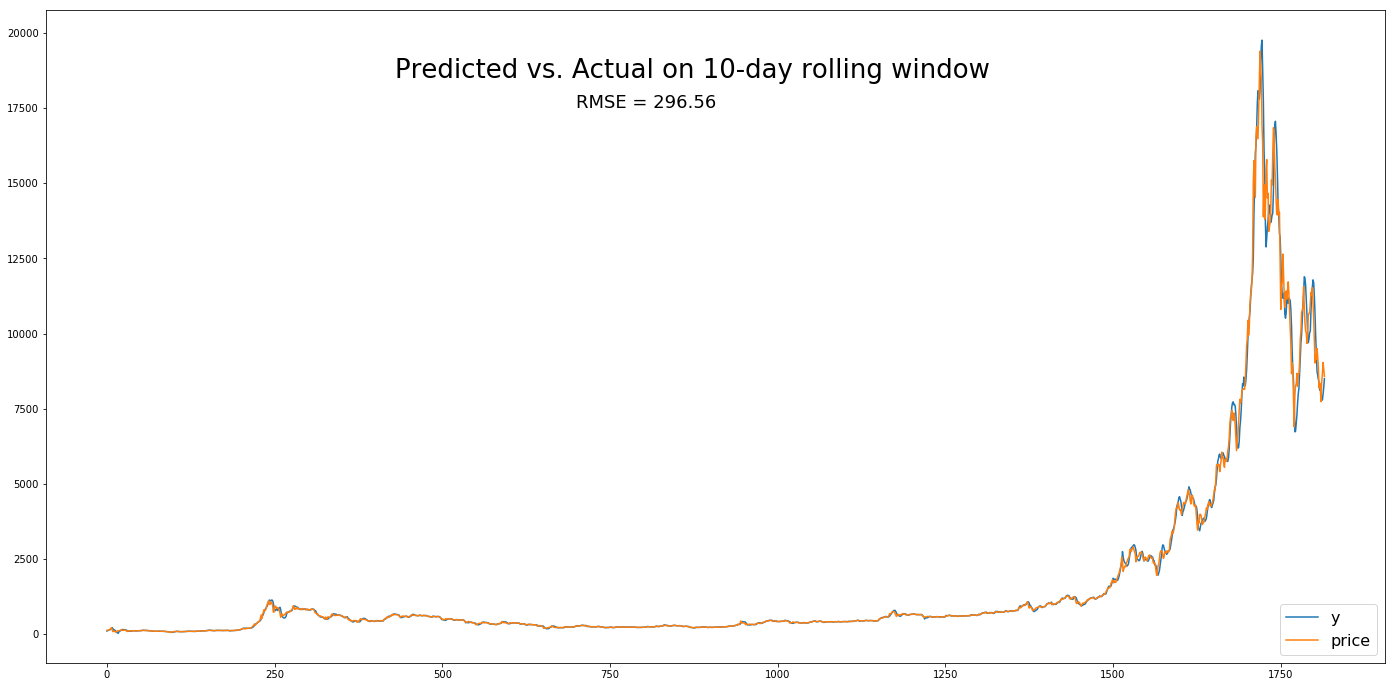

In [53]:
plt.figure(figsize=(24,12))
plt.plot(dfnew['y'])
plt.plot(dfnew['price'])
plt.legend(loc=4, fontsize=16)
plt.text(430, 18500, 'Predicted vs. Actual on 10-day rolling window', fontsize=26)
plt.text(700, 17500, 'RMSE = 296.56', fontsize=18)
plt.show()

In [35]:
y_hat = dfnew['y']
y_true = dfnew['price']

mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 87946.37 MSE (296.56 RMSE)


## 4. Predicting based on log of  data
Data is log-transformed prior to modeling.  
  
Prediction quality: 655.05 RMSE

In [36]:
# Take a log
logdata = data
logdata['y'] = np.log(logdata['y'])

In [37]:
logdata.tail()

,ds,epu_idx,y,volume,bidask,tpm,trans,exp_sem
1821,2018-03-19,76.32,9.034852,1.331577e+09,1.237513,44.369544,191528,0.095283
1822,2018-03-20,79.32,9.067079,9.671192e+08,0.931973,33.673810,195168,0.109729
1823,2018-03-21,58.73,9.109231,9.017038e+08,0.481224,30.921032,194846,0.159660
1824,2018-03-22,54.22,9.085693,9.567951e+08,0.339547,29.067163,185187,0.092254
1825,2018-03-23,72.98,9.056532,8.645390e+08,0.347265,30.230258,179818,0.113480


In [40]:
# Remove log and plot
y_hat = np.exp(f5['yhat'])
y_true = np.exp(logdata['y'])

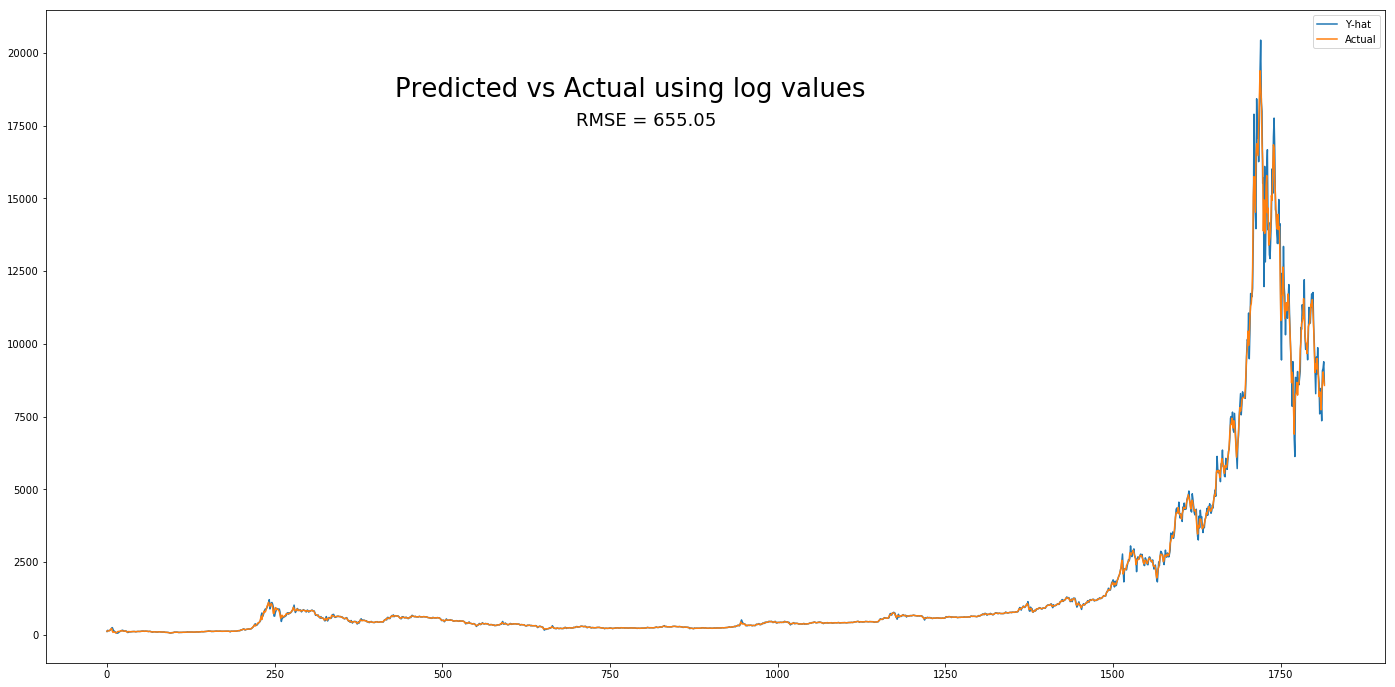

In [50]:
plt.figure(figsize=(24,12))
plt.plot(y_hat, label='Y-hat')
plt.plot(y_true, label='Actual')
plt.legend(loc=4, fontsize=16)
plt.text(430, 18500, 'Predicted vs Actual using log values', fontsize=26)
plt.text(700, 17500, 'RMSE = 655.05', fontsize=18)
plt.show()

In [42]:
# Calculate Accuracy
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 429096.47 MSE (655.05 RMSE)


### 4. Predicting based on Rolling window of 10 using log  
  
Prediction quality: 233.41 RMSE

In [43]:
# This will take some time to run
y = []
p = []
for i in range(0,len(logdata)):
    if (i+11)>len(logdata):
        print ('Completed')
        break
        
    df = logdata[i:i+10]
    y.append(runmodel(df))
    p.append(logdata['y'][i+10])
    #print('Processed', i)

Completed


In [44]:
dfrolling=pd.DataFrame({'y':y, 'price':p})

In [45]:
#Remove log
y_hat = np.exp(dfrolling['y'])
y_true = np.exp(dfrolling['price'])

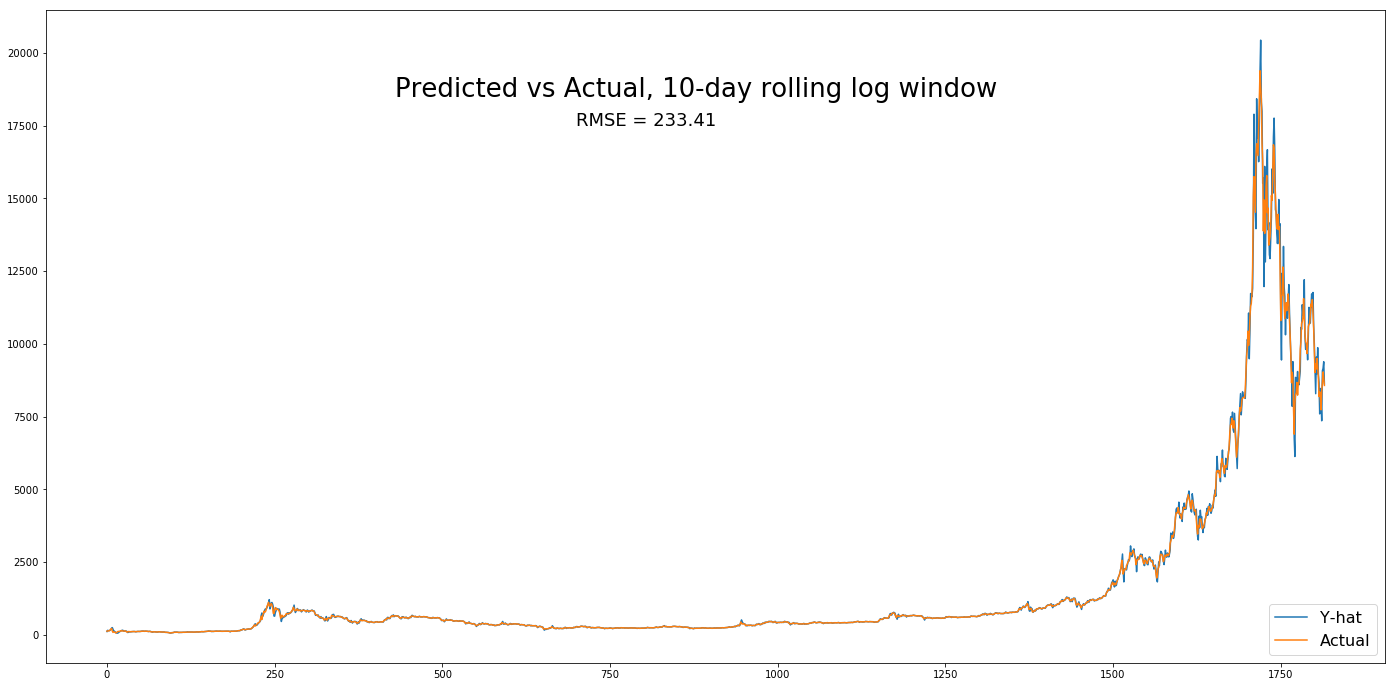

In [52]:
plt.figure(figsize=(24,12))
plt.plot(y_hat, label='Y-hat')
plt.plot(y_true, label='Actual')
plt.legend(loc=4, fontsize=16)
plt.text(430, 18500, 'Predicted vs Actual, 10-day rolling log window', fontsize=26)
plt.text(700, 17500, 'RMSE = 233.41', fontsize=18)
plt.show()

In [47]:
#Calculate accuracy
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 54481.25 MSE (233.41 RMSE)


Code references

https://facebook.github.io/prophet/docs/quick_start.html

http://pythondata.com/stock-market-forecasting-with-prophet/

http://dacatay.com/data-science/part-5-time-series-prediction-prophet-python/